批处理ESD表格，主要把时间戳转化为时间轴

In [ ]:
import os
import pandas as pd

dirlist = os.listdir('../CollectedData/BINS/')
print(dirlist)
for i in dirlist:
    data = pd.read_csv('../CollectedData/BINS/'+i)
    time_df = data.iloc[:,0] # 获取时间戳的那一列
    bins_df = data.iloc[:,1:-1] # 获取bins的列
    data['max'] = bins_df.max(axis=1) # 找到bins中每一行的最大值，并且赋值给max列
    data['time'] = (time_df-time_df[0])/1000
    output = data[['time','max']]
    output.to_csv('../CollectedData/OutBINS/out_'+i, index=False)

超声波信号和音频信号相乘

In [115]:
from utils.soundBase import soundBase
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy.interpolate as spi
import numpy as np

sb = soundBase('../CollectedData/WAV/SingleWav6.wav') # 读取音频文件
audio_data , fs = sb.audioread()
esd_df = pd.read_csv('../CollectedData/OutBINS/out_TEST_BINS6.csv') # 读取ESD数据文件
esd_time = esd_df['time']
esd_data = esd_df['max']

# 音频幅值归一化
min_max_scaler1 = MinMaxScaler(feature_range=(-1,1),copy=True) # 定义归一化的范围为[-1,1]
audio_data_minmax = min_max_scaler1.fit_transform(audio_data.reshape(-1,1))
# sb.soundplot(audio_data_minmax,sr=fs)

# 超声波幅值归一化
min_max_scaler2 = MinMaxScaler(feature_range=(0,1),copy=True) # 定义归一化的范围为[0,1]
esd_data_minmax = min_max_scaler2.fit_transform(esd_data.values.reshape(-1,1))
# plt.plot(esd_time.values,esd_data_minmax)
# 音频下采样
audio_data_minmax_downsampled = librosa.resample(y=audio_data_minmax.reshape(1,-1),orig_sr = fs, target_sr= 16000) # 下采样至16Khz

# 超声波上采样
time = [i / 16000 for i in range(len(audio_data_minmax_downsampled.reshape(-1,1)))] # 音频的时间点
ipo1=spi.splrep(esd_time.values,esd_data_minmax,k=1) # 样本点导入，生成参数
upsample_esd =spi.splev(time,ipo1) # 根据观测点和样条参数，生成插值，观测点设置为音频的时间坐标
# plt.plot(esd_time.values,esd_data_minmax,'o',label='样本点')
# plt.plot(time,upsample_esd,label='插值点')
# plt.ylim(esd_data.values.min(),esd_data.values.max()+1)
# plt.ylabel('指数')
# plt.title('线性插值')
# plt.legend()

multilsignal = np.multiply(upsample_esd,audio_data_minmax_downsampled.reshape(-1,1).squeeze())

相乘信号低通滤波，然后进行谱熵法的端点检测

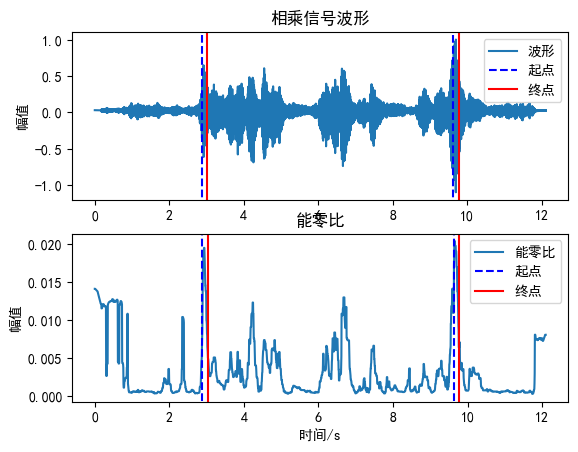

In [121]:
from utils.speechlib import *
fs = 16000
multilsignal = multilsignal - np.mean(multilsignal)
multilsignal = multilsignal / np.max(multilsignal)
IS = 0.25
wlen = 200
inc = 80
N = len(multilsignal)
time = [i / fs for i in range(N)]
wnd = np.hamming(wlen)
overlap = wlen - inc
NIS = int((IS * fs - wlen) // inc + 1)

mode = 1
if mode == 1:
    thr1 = 1
    thr2 = 1.3
    tlabel = '能零比'
elif mode == 2:
    thr1 = 0.05
    thr2 = 0.1
    tlabel = '能熵比'
voiceseg, vsl, SF, NF, Epara = vad_pro(multilsignal, wnd, inc, NIS, thr1, thr2, mode)

fn = len(SF)
frameTime = FrameTimeC(fn, wlen, inc, fs)

plt.subplot(2, 1, 1)
plt.plot(time, multilsignal)
plt.title('相乘信号波形')
plt.ylabel('幅值')

plt.subplot(2, 1, 2)
plt.plot(frameTime, Epara)
plt.title(tlabel)
plt.xlabel('时间/s')
plt.ylabel('幅值')

for i in range(vsl):
    nx1=voiceseg[i]['start']
    nx2=voiceseg[i]['end']
    plt.subplot(2, 1, 1)
    plt.axvline(frameTime[nx1], np.min(multilsignal), np.max(multilsignal), color='blue', linestyle='--')
    plt.axvline(frameTime[nx2], np.min(multilsignal), np.max(multilsignal), color='red', linestyle='-')
    plt.legend(['波形', '起点', '终点'])

    plt.subplot(2, 1, 2)
    plt.axvline(frameTime[nx1], np.min(Epara), 1.0, color='blue', linestyle='--')
    plt.axvline(frameTime[nx2], np.min(Epara), 1.0, color='red', linestyle='-')
    plt.legend([tlabel, '起点', '终点'])

plt.show()